# Brief analyse de données

Aude Pertron - Paul Sabia - Julien Furiga

## Choix de la base de données

Nous avons choisi la base de donnée NBA Games data [(ici)](https://www.kaggle.com/nathanlauga/nba-games) qui reprend les données des matchs des 14 dernieres saisons. 
La base est composée de 5 fichiers CSV. 

## Traitement sur les fichiers CSV


* Suppression de colonnes contenant des informations non pertinantes
* Suppression des colonnes calculables

### Fichier game detail :

* Suppression des NaNs en python

```
import pandas as pd

data=pd.read_csv("C:/temp/games_details.csv",sep=",")

data=data.fillna(0)
data.to_csv(r'C:/temp/games_details_good.csv',index=False)```

### Fichier player

* Isolation des joueurs et suppressions des doublons afin de recuperer les noms de joueurs et leurs id pour la création d'une table spécifique

## Création du MCD

![img](https://media.discordapp.net/attachments/788326293229142016/788354040961695774/mcd.PNG?width=564&height=675)

## Création de la base de donnée

Création de la base de donnée via SQL Power Architect, puis importation des fichiers csv retravaillés en ligne de commande.


# Travail sur la base de donnée 

## Création des vues 

## Classement de l'année 2019

``` SQL
CREATE VIEW classement_2019 AS
SELECT teams.city,teams.nickname,ranking.conference,ranking.win,ranking.lose 
FROM ranking 
JOIN teams ON ranking.team_id=teams.team_id
WHERE season_id=22019 
ORDER BY conference,win DESC 
```

## Moyenne en carriere des joueurs 

``` SQL 
CREATE VIEW Stats_all_players_3 AS
SELECT player.player_name, AVG(pts), AVG(oreb), AVG(dreb), AVG(ast), AVG(stl),  AVG(blk), AVG(turn_over)
FROM games_details
JOIN player ON games_details.player_id = player.player_id
GROUP BY games_details.player_id
ORDER BY SUM(games_details.pts) DESC


# Création des procédures 

## Procédure donnant la liste des joueurs d'une équipe choisie pour une année donnée

``` SQL
DELIMITER //
CREATE PROCEDURE get_team_players(team VARCHAR(15),season YEAR)
BEGIN 
    SELECT player.player_name,teams.nickname FROM player_team
    JOIN teams ON teams.team_id=player_team.team_id
    JOIN player ON player.player_id=player_team.player_id
    WHERE player_team.season=season 
    AND player_team.team_id=(
        SELECT team_id FROM teams WHERE city=team
    );
END
DELIMITER ;
```

## Procedure donnant le pourcentage au shoot a 3 points d'un joueur pour tout les matchs d'une saison

``` SQL

DELIMITER //
CREATE PROCEDURE get_players_3pts_mean(player varchar(50),saison INT)
BEGIN
    SELECT fg3a,fg3m,season,(SELECT (fg3m/fg3a)*100 as mean) FROM games_details 
    JOIN games ON games_details.game_id=games.game_id
    WHERE player_id=(SELECT player_id FROM player where player_name=player) AND season=saison;
    
END
DELIMITER ;
``` 
## Procedure retournant les resultats des matchs a domicile pour une saison donnée

```SQL
DELIMITER |
CREATE PROCEDURE matches(IN annee YEAR(4), nick VARCHAR(20))
BEGIN 
SELECT nickname, home_team_win FROM teams, games
WHERE games.visitor_team_id = teams.team_id AND games.home_team_id = (SELECT team_id FROM teams WHERE abreviation = nick) AND games.season = annee ORDER BY nickname;
END|
DELIMITER ;
```

## Recupération des stats d'un joueur dans une vue 

```SQL
DELIMITER //
CREATE PROCEDURE stats_player
(IN name VARCHAR(50))
BEGIN
SELECT *
FROM Stats_all_players_3
WHERE player_name=name;
END//


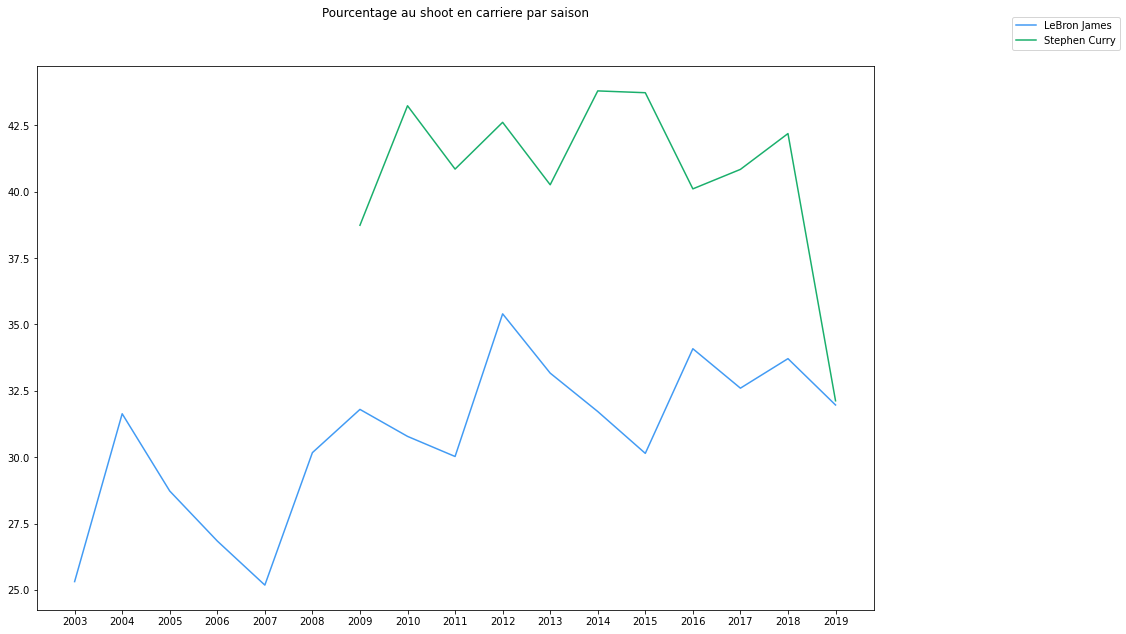

In [1]:
from connector_nba import BDD
import matplotlib.pyplot as plt

stephen_curry = BDD.getPlayer3ptsPctCarrier("Stephen Curry")
lebron_james=BDD.getPlayer3ptsPctCarrier("LeBron James")
fig, ax = plt.subplots(figsize=(15, 10))
ax.plot(lebron_james.groupby(['saison']).mean(),color='#429bf4',label="LeBron James" )
ax.plot(stephen_curry.groupby(['saison']).mean(),color='#1aaf6c',label="Stephen Curry" )

ax.set_title('Pourcentage au shoot en carriere par saison', y=1.08)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))


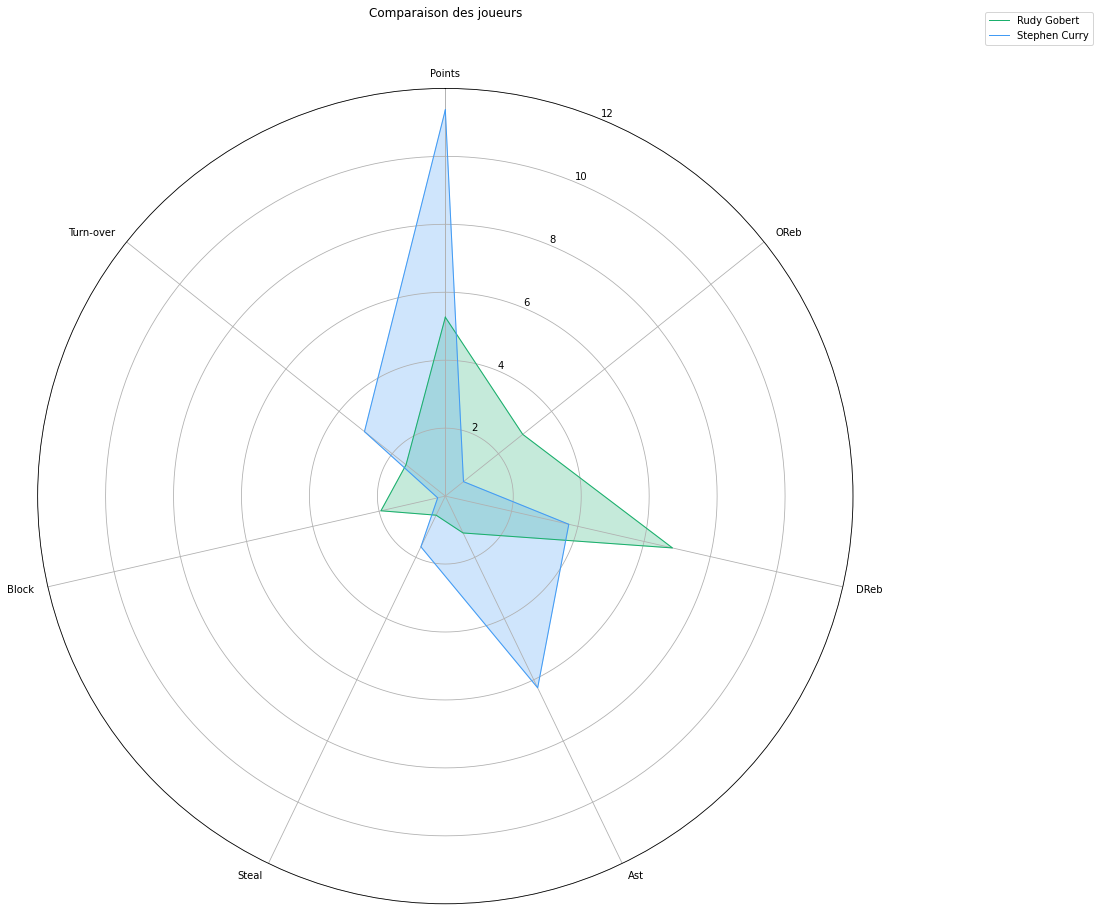

In [2]:
from connector_nba import BDD
import numpy as np
import matplotlib.pyplot as plt 

def add_to_radar(player, label,color):
  values = player
  values += values[:1]
  ax.plot(angles, values, color=color, linewidth=1, label=label)
  ax.fill(angles, values, color=color, alpha=0.25)


rudy_gobert=BDD.getPlayerStatsCarrier('Rudy Gobert')
stephen_curry=BDD.getPlayerStatsCarrier('Stephen Curry')
labels=["Points","OReb","DReb","Ast","Steal","Block","Turn-over"]
# Number of variables we're plotting.
num_vars = len(labels)

# Split the circle into even parts and save the angles
# so we know where to put each axis.
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

# The plot is a circle, so we need to "complete the loop"
# and append the start value to the end.
angles += angles[:1]

# ax = plt.subplot(polar=True)
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(polar=True))

add_to_radar(rudy_gobert,"Rudy Gobert",'#1aaf6c')
add_to_radar(stephen_curry,"Stephen Curry",'#429bf4')

ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_ylim(0, 12)
# Draw axis lines for each angle and label.
ax.set_thetagrids(np.degrees(angles), labels)
for label, angle in zip(ax.get_xticklabels(), angles):
  if angle in (0, np.pi):
    label.set_horizontalalignment('center')
  elif 0 < angle < np.pi:
    label.set_horizontalalignment('left')
  else:
    label.set_horizontalalignment('right')

# Add title.
ax.set_title('Comparaison des joueurs', y=1.08)

# Add a legend as well.
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))



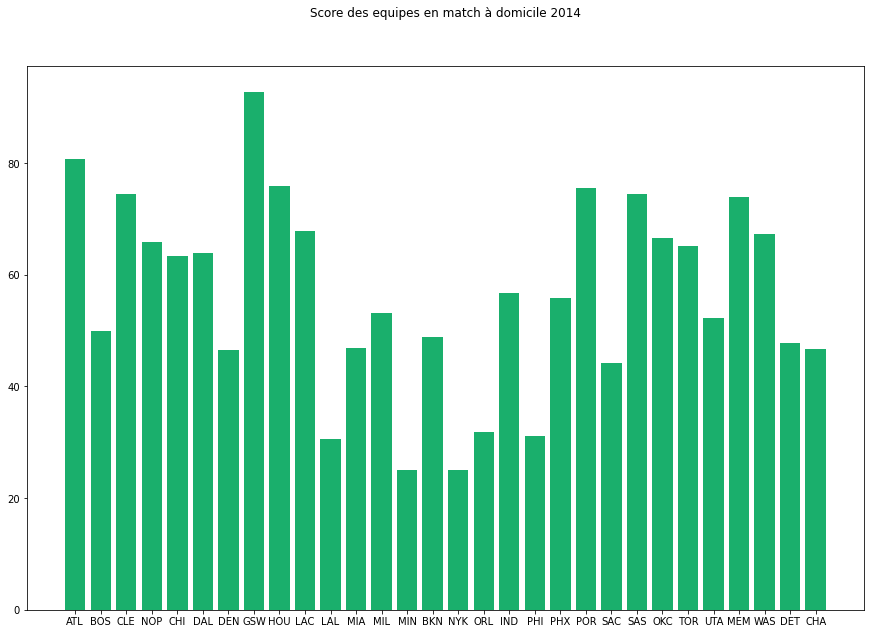

In [7]:
from connector_nba import BDD

def stats_victoires(donnees):
    total = len(donnees)
    win = 0
    for i in range (len(donnees)):
        if donnees[i][1] == 1:
            win += 1
    taux = round((win/total*100),2)           
    return taux


teams = BDD.all_teams()

def liste_scores(teams):
    score = []
    team_dict = {}
    for j in range (len(teams)):
        equipe = teams[j][0]
        
        base_score = BDD.milwaukee(equipe, 2014)
        
        stats = stats_victoires(base_score)
        team_dict[equipe] = stats
        score.append(stats)
    return score, team_dict

stats_matchs, team_dict = liste_scores(teams)

fig, ax = plt.subplots(figsize=(15, 10))

ax.set_title('Score des equipes en match à domicile 2014', y=1.08)


ax.bar(*zip(*team_dict.items()),color='#1aaf6c')

plt.show()